In [108]:
#imports
import numpy as np
import pandas as pd


np.random.seed(123)


#plotting tools
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

#data prep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#feature selection:
from sklearn.feature_selection import SelectKBest, chi2

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### Classification

Build a classification model for the default of credit card clients dataset.

- Use 2 classifiers.
    - Random Forest
        - tune only: n_estimators: {4, 5, 10, 20, 50} 
    - KNN Classfier 
        - tune only: n_neighbors: {3, 5, 10, 20} 


# Data

Data is obtained from a public datasert of the University of California, Irvine Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). 

In [2]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", 
                   skiprows= 1, header = 0)

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


BAsed on the dataset description obtained form teh website:

* **LIMIT_BAL**: Amount of given credit (in NT dollars) for the invidiual consumer credit and his/her family credit

* **GENDER**:
    * 1 = Male
    * 2 = Female

* **EDUCATION**: 
    * 1 = Graduate school
    * 2 = University
    * 3 = High School
    * 4 = Others 

* **MARITAL STATUS**:
    * 1 = Married
    * 2 = Single
    * 3 = Others

* **AGE**: In years

* **PAY_#**: History of past monthly payment records (April 2005 to September 2005). The scale is  
    * -1 = Duly paid
    * 1 = One month delay
    * 2 = 2 month delay 
    ...
    * N = N month delay
    
* **BILL_AMT#**: Amount on bill statement (in NT dollars) from April 2005 to September 2005

* **PAY_AMT#**: Amount of previous payment (in NT dollars) from April 20015 to September 2005

* **default payment next month**: The data label
    * 0 = Did not default
    * 1 = Default

In [5]:
df.columns
names = df.columns.to_list()

In [6]:
#to make column names consistent and easier to work with
df = df.rename(columns = {'PAY_0':'PAY_1', 'default payment next month': "default"})
column_names = dict(zip(names, (i.lower() for i in names)))
df=df.rename(columns = column_names)
df.head()

,id,limit_bal,sex,education,marriage,age,PAY_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


# EDA

In [7]:
df.info()
# there are no missing values and all data has integer data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         30000 non-null  int64
 1   limit_bal  30000 non-null  int64
 2   sex        30000 non-null  int64
 3   education  30000 non-null  int64
 4   marriage   30000 non-null  int64
 5   age        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   pay_2      30000 non-null  int64
 8   pay_3      30000 non-null  int64
 9   pay_4      30000 non-null  int64
 10  pay_5      30000 non-null  int64
 11  pay_6      30000 non-null  int64
 12  bill_amt1  30000 non-null  int64
 13  bill_amt2  30000 non-null  int64
 14  bill_amt3  30000 non-null  int64
 15  bill_amt4  30000 non-null  int64
 16  bill_amt5  30000 non-null  int64
 17  bill_amt6  30000 non-null  int64
 18  pay_amt1   30000 non-null  int64
 19  pay_amt2   30000 non-null  int64
 20  pay_amt3   30000 non-null  int64
 21  pay_amt4   3

In [8]:
df.describe()
#there doesn't seem to be any obvious errors with the data. Seems like a good quality dataset

,id,limit_bal,sex,education,marriage,age,PAY_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [9]:
#we will visualize some of the important attributes
visual=df.iloc[:,[1,2,3,4,5,-1]]

In [10]:
visual

,limit_bal,sex,education,marriage,age,default
0,20000,2,2,1,24,1
1,120000,2,2,2,26,1
2,90000,2,2,2,34,0
3,50000,2,2,1,37,0
4,50000,1,2,1,57,0
...,...,...,...,...,...,...
29995,220000,1,3,1,39,0
29996,150000,1,3,2,43,0
29997,30000,1,2,2,37,1
29998,80000,1,3,1,41,1


In [11]:
categ = visual[['sex', 'education', 'marriage']]
num = visual[['limit_bal','age']]

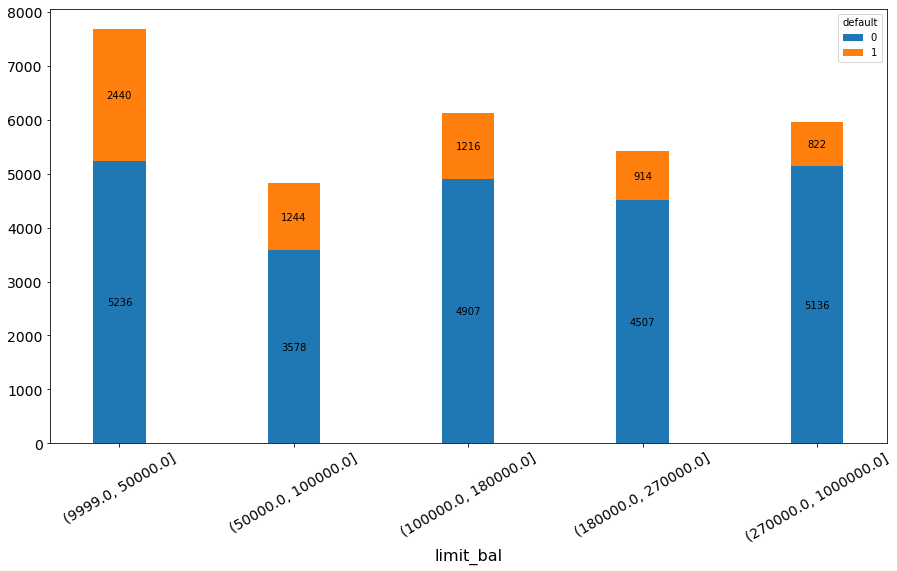

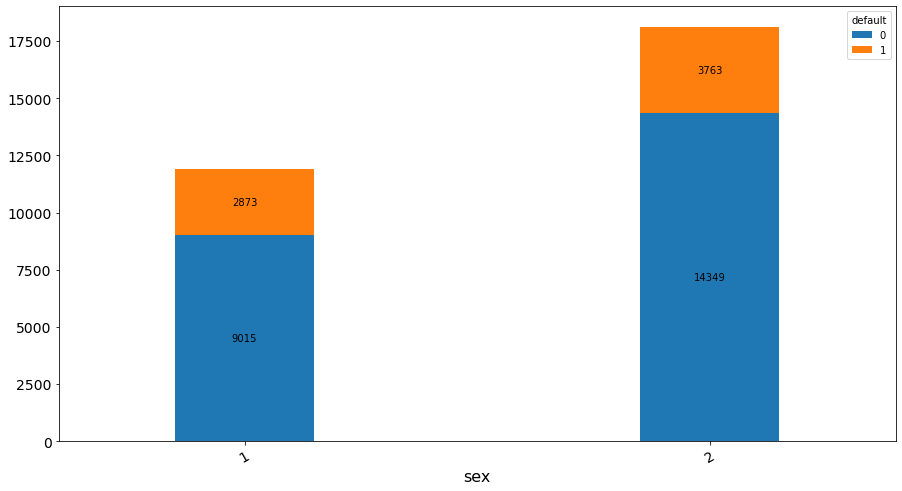

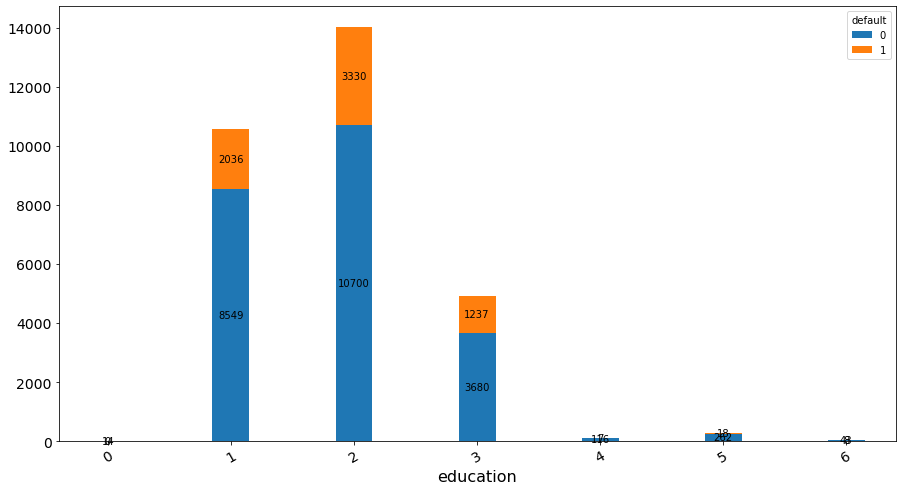

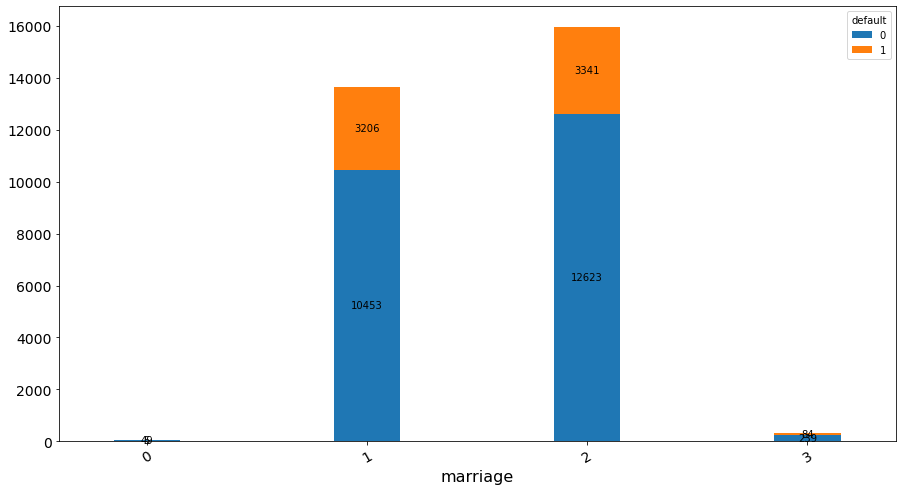

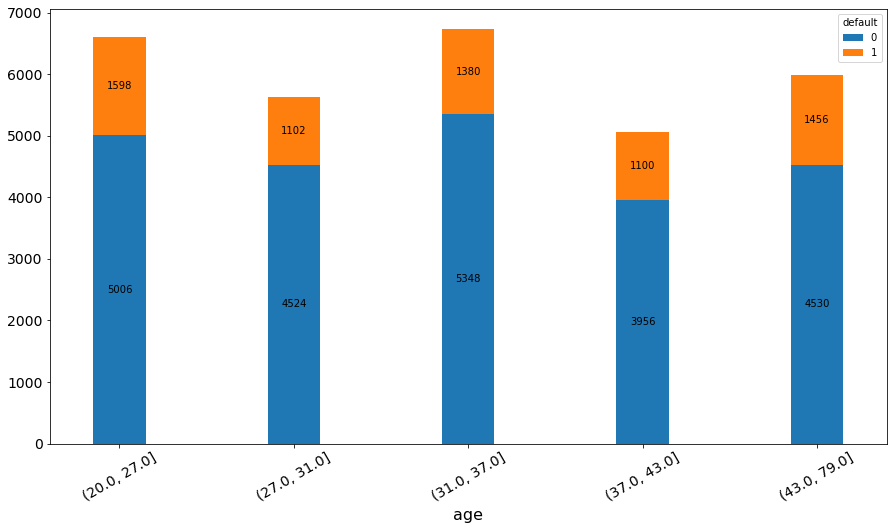

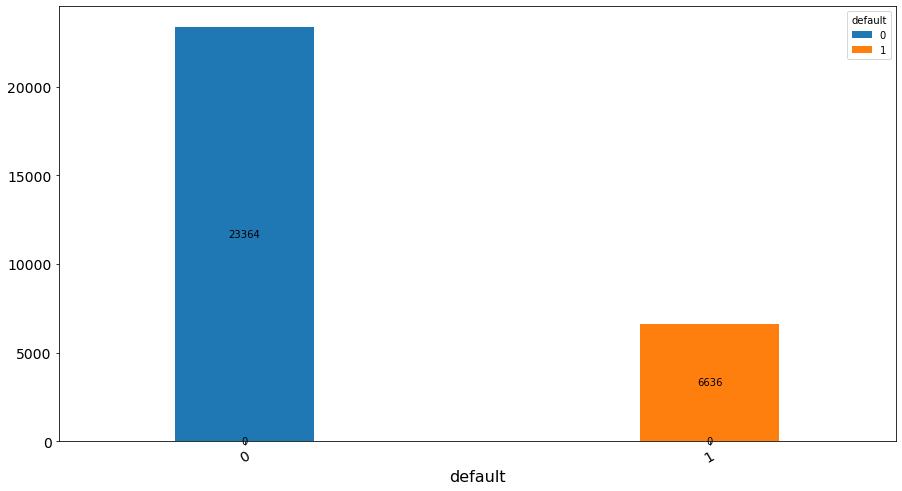

In [12]:
for count,value in enumerate(visual):
    #print(count)
    if value in num:
        df_crosstab = pd.crosstab(pd.qcut(visual[value], 5, precision = 0), visual['default'])
    else:
        df_crosstab = pd.crosstab(visual[value], visual['default'])
        
    g = df_crosstab.plot(kind='bar', stacked=True, width = 0.3,rot=30, figsize=(15, 8))
    for c in g.containers:
        labels = [v.get_height() for v in c]
        plt.bar_label(container = c, label = labels, label_type = 'center');
        
plt.show();

### Based on the plots above, there seems to be correlation between the credit limit and defaults - the lowest limit customers seem to default more often. There also seems to be less defaulting in middle age group (31-37)


### We will run a Random Forest Classifier both as a baseline model and a feature selection method. We will also try to do feature engineering - combine pay amt features into one and bill amt feautures into one to see if this will lead to a better performance.

In [82]:
X = df.iloc[:,1:-1] #we will not include ID into features, as it has no bearing on defaulting.
y = df.iloc[:,-1]

In [75]:
X_tr, X_te, y_tr, y_te = train_test_split(X,y, test_size = 0.2)

In [76]:
rf_clf = RandomForestClassifier(class_weight = 'balanced')

In [53]:
rf_clf.fit(X_tr,y_tr)

RandomForestClassifier(class_weight='balanced')

In [54]:
#Now we'll try to fit our RF model and see if it gives us good performance from the get go
cv_scores = cross_val_score (rf_clf, X_tr, y_tr, cv = 5)
cv_scores

array([0.81375   , 0.818125  , 0.813125  , 0.81458333, 0.81416667])

In [55]:
feats = rf_clf.feature_importances_
feat_names = X.columns.to_list()

In [56]:
importances = zip(feats,feat_names) #finding the most important features according to RF
feat_imp=sorted(list(importances),reverse = True)
feat_imp

[(0.09179237489896105, 'PAY_1'),
 (0.061945016064869775, 'age'),
 (0.061910618373775504, 'bill_amt1'),
 (0.06186005722502215, 'limit_bal'),
 (0.05432478288707336, 'pay_amt1'),
 (0.05432314270488017, 'bill_amt2'),
 (0.05317417869076972, 'pay_amt2'),
 (0.05008168304675355, 'bill_amt3'),
 (0.049655051413279715, 'bill_amt4'),
 (0.04947010707850981, 'pay_amt3'),
 (0.0486618097726663, 'bill_amt6'),
 (0.04806511805199214, 'bill_amt5'),
 (0.04636645259902445, 'pay_amt6'),
 (0.04585087858685228, 'pay_2'),
 (0.044496567541197955, 'pay_amt4'),
 (0.04339823503376465, 'pay_amt5'),
 (0.03086247519483946, 'pay_3'),
 (0.02391659214788999, 'pay_4'),
 (0.019887214754976488, 'education'),
 (0.01985325546255214, 'pay_5'),
 (0.016320294008305276, 'pay_6'),
 (0.012871878297886257, 'marriage'),
 (0.010912216164157587, 'sex')]

In [57]:
feat_to_keep = [i[1] for i in feat_imp[:10]] 
feat_to_keep

['PAY_1',
 'age',
 'bill_amt1',
 'limit_bal',
 'pay_amt1',
 'bill_amt2',
 'pay_amt2',
 'bill_amt3',
 'bill_amt4',
 'pay_amt3']

### The scores are not very high. we will try to do some feature engineering - namely combine pay_amt and bill_amt features into one

In [83]:
#"pay" features are categorical, we will use "mode" of the 6 columns to create a new feature
#to avoid overwriting X:
X_feat_eng = X.copy()
X_feat_eng['pay_mode'] = X_feat_eng.iloc[:,6:12].mode(axis = 1)[0]

In [84]:
X

,limit_bal,sex,education,marriage,age,PAY_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29996,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100
29998,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804


In [85]:
X_feat_eng.iloc[:,12:18]

,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1
0,3102,689,0,0,0,0
1,1725,2682,3272,3455,3261,0
2,14027,13559,14331,14948,15549,1518
3,48233,49291,28314,28959,29547,2000
4,5670,35835,20940,19146,19131,2000
...,...,...,...,...,...,...
29995,192815,208365,88004,31237,15980,8500
29996,1828,3502,8979,5190,0,1837
29997,3356,2758,20878,20582,19357,0
29998,78379,76304,52774,11855,48944,85900


In [86]:
#  "bill amt" features are numerical, we will use mean to create an 6-mth average
X_feat_eng['bill_amt_mean'] = X_feat_eng.iloc[:,11:17].mean(axis = 1)

In [87]:
X_feat_eng

,limit_bal,sex,education,marriage,age,PAY_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,pay_mode,bill_amt_mean
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,-2.0,1284.000000
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0.0,2846.166667
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0.0,16942.166667
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0.0,38555.666667
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0.0,18223.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0.0,120891.500000
29996,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,-1.0,3530.333333
29997,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,0.0,11749.333333
29998,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,0.0,44435.166667


In [88]:
# lastly, we will combine pay_amt features into one 
X_feat_eng['pay_amt'] = X_feat_eng.iloc[:,17:23].mean(axis = 1)

In [89]:
#We can now remove the excessive features
X_feat_eng=X_feat_eng.drop((df.iloc[:, 6:24]), axis = 1)
X_feat_eng

,limit_bal,sex,education,marriage,age,pay_mode,bill_amt_mean,pay_amt
0,20000,2,2,1,24,-2.0,1284.000000,114.833333
1,120000,2,2,2,26,0.0,2846.166667,833.333333
2,90000,2,2,2,34,0.0,16942.166667,1836.333333
3,50000,2,2,1,37,0.0,38555.666667,1398.000000
4,50000,1,2,1,57,0.0,18223.166667,9841.500000
...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0.0,120891.500000,7091.666667
29996,150000,1,3,2,43,-1.0,3530.333333,2415.000000
29997,30000,1,2,2,37,0.0,11749.333333,5216.666667
29998,80000,1,3,1,41,0.0,44435.166667,24530.166667


In [90]:
X_tr_feat_eng, X_te_feat_eng, y_tr, y_te = train_test_split(X_feat_eng,y, test_size = 0.2)

In [91]:
# now let's run RF on the new dataset
cv_scores_feat_eng = cross_val_score (rf_clf, X_tr_feat_eng, y_tr, cv = 5)
cv_scores_feat_eng

array([0.79166667, 0.79375   , 0.791875  , 0.78895833, 0.79291667])

### From what we can see, feature engineering actually reduced accuracy for RF model. We will try and test other models to see what gives us the best results.

In [92]:
#for other models we will need to prepare our numerical and categorical features. 
# We'll create a pipeline for data prep.
categ = ['sex', 'education', 'marriage', 'PAY_1', 'pay_2','pay_3','pay_4', 'pay_5', 'pay_6']
num = X.drop(categ, axis = 1).columns.tolist()
num

['limit_bal',
 'age',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6']

In [123]:
X[categ].nunique()

sex           2
education     7
marriage      4
PAY_1        11
pay_2        11
pay_3        11
pay_4        11
pay_5        10
pay_6        10
dtype: int64

In [109]:
cat_ohe_step = OneHotEncoder(handle_unknown='ignore')
num_scl_step = StandardScaler()

In [110]:
preprocessor = ColumnTransformer([('cat', cat_ohe_step, categ),
                       ('num', num_scl_step, num)])

In [95]:
#we'll fit on the training set only to avoid peeking at data distribution
#ct.fit(X_tr[categ+ num])
#X_tr_prepped = ct.transform(X_tr[categ+num])

X_tr_prepped

In [124]:
#Logistic regression:
log_reg = LogisticRegression(class_weight = 'balanced', max_iter = 500)

In [125]:
latest_model = log_reg

In [126]:
clf = Pipeline(
    steps = [('preprocessor', preprocessor), ('classifier', latest_model)]
)

In [127]:
clf.fit(X_tr[categ+num], y_tr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sex', 'education',
                                                   'marriage', 'PAY_1', 'pay_2',
                                                   'pay_3', 'pay_4', 'pay_5',
                                                   'pay_6']),
                                                 ('num', StandardScaler(),
                                                  ['limit_bal', 'age',
                                                   'bill_amt1', 'bill_amt2',
                                                   'bill_amt3', 'bill_amt4',
                                                   'bill_amt5', 'bill_amt6',
                                                   'pay_amt1', 'pay_amt2',
                                                   'pay_amt3', 'pay_amt4',
 

In [ ]:
cross_val_score(clf,X_tr[categ+num], y_tr, cv=5 )

In [140]:
cv_score_log_reg = cross_val_score(log_reg, X_tr, y_tr, cv = 5)
cv_score_log_reg

array([0.5575    , 0.52770833, 0.53875   , 0.55354167, 0.56666667])

In [ ]:
#logistic regression pe